In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
cc_info = pd.read_csv('credit_card/cc_info.csv')
transactions = pd.read_csv('credit_card/transactions.csv',parse_dates = ['date'])
data = pd.merge(transactions,cc_info,how='left')
data['month'] = data['date'].dt.month

In [3]:
users_above_limit = data.groupby(['credit_card', 'month']).apply(lambda x: pd.Series({'credit_card_limit': x['credit_card_limit'].min(),'total_spent': x['transaction_dollar_amount'].sum()})).reset_index()
users_above_limit = users_above_limit.query('total_spent>credit_card_limit')['credit_card'].unique()

In [4]:
year = datetime.date.today().year
month = datetime.date.today().month

In [5]:
user_daily = data[np.logical_and(data.date.dt.year == 2015,data.date.dt.month == 9)].groupby('credit_card').apply(lambda x: pd.Series({'above_limit':x.transaction_dollar_amount.sum()>x.credit_card_limit.max()})).reset_index()
daily_above = user_daily[user_daily['above_limit']].credit_card

In [6]:
import geocoder
import geopy.distance
data['api_String'] = data.city +','+ data.state +',' + data.zipcode.map(str)
string = data.api_String.unique()
city_api = pd.DataFrame({'string':string,'city_long':np.nan,'city_lat':np.nan})

In [7]:
for i in range(len(string)):
    geocode_add = geocoder.bing(city_api['string'][i], key='AlAyWJO_PbQZ_SHeicAAZ4-r9_9hlrbkyMX0SxDqMrOro_SY6ErZhvls21svcdkp').latlng
    city_api.at[i,'city_lat'],city_api.at[i,'city_long'] = geocode_add[0],geocode_add[1]

In [8]:
data = pd.merge(data,city_api,how='left',left_on='api_String',right_on='string')
data = data.sort_values('date').reset_index()

In [13]:
data['distance_from_home'] = data.apply(lambda x: geopy.distance.distance(x[["Lat", "Long"]], x[["city_lat", "city_long"]]).km,axis=1)

In [14]:
data['time_delta_consecutive_transactions'] = data.groupby('credit_card').date.diff()
data['time_delta_consecutive_transactions'] = data['time_delta_consecutive_transactions'].apply(lambda x: x.total_seconds()/60)
data[['Lat_shifted','Long_shifted']] = data.groupby('credit_card')[['Lat','Long']].shift(1)

In [15]:
data['distance_consecutive_transactions'] = data.apply(lambda x:x['Lat_shifted'] if pd.isnull(x['Lat_shifted']) else geopy.distance.distance(x[['Lat','Long']],x[['Lat_shifted','Long_shifted']]).km,axis=1)

In [16]:
data_cluster = data[['credit_card','distance_from_home','time_delta_consecutive_transactions','distance_consecutive_transactions','transaction_dollar_amount']]

In [17]:
data_cluster

,credit_card,distance_from_home,time_delta_consecutive_transactions,distance_consecutive_transactions,transaction_dollar_amount
0,9484591448272784,7.743087,NaN,NaN,17.99
1,7053196367895112,7.145374,NaN,NaN,12.09
2,9528285469413252,8.338901,NaN,NaN,78.21
3,1845720274833905,7.456662,NaN,NaN,74.41
4,7850942767136368,6.922782,NaN,NaN,54.89
...,...,...,...,...,...
294583,2954456265698260,3.469500,320.716667,9.798998,20.18
294584,5142934429645149,3.944692,369.566667,9.566272,9.03
294585,6483234875464386,1.008439,499.333333,6.600406,197.75
294586,8413908390816172,5.783076,228.250000,8.080012,233.61


In [173]:
data_cluster = data_cluster.groupby('credit_card').transform(lambda x: (x-x.mean())/x.std())

In [174]:
data_cluster = data_cluster.dropna()

In [176]:
data_cluster.describe()

,distance_from_home,time_delta_consecutive_transactions,distance_consecutive_transactions,transaction_dollar_amount
count,293601.000000,2.936010e+05,2.936010e+05,293601.000000
mean,-0.000064,-6.719360e-17,-1.051608e-18,-0.000008
std,0.998180,9.983348e-01,9.983348e-01,0.998161
min,-2.972391,-1.554428e+00,-2.396870e+00,-2.412378
25%,-0.130925,-5.976848e-01,-1.855413e-01,-0.323753
50%,-0.115063,-4.556891e-01,-1.626064e-01,-0.143472
75%,-0.097015,9.136592e-02,-1.357169e-01,0.062784
max,21.840052,9.278361e+00,1.541512e+01,15.943140


In [177]:
from sklearn.cluster import KMeans
sse = []
for i in range(1,10):
    sse.append(KMeans(n_clusters=i,init='k-means++',random_state=10).fit(data_cluster).inertia_)
plt.plot(range(1,10),sse)

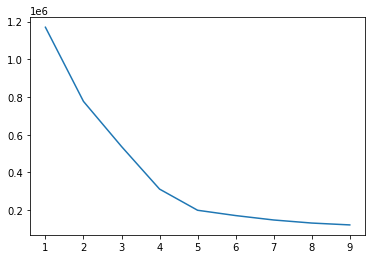

In [180]:
plt.plot(range(1,10),sse)

In [183]:
clusters = KMeans(n_clusters=7,init='k-means++',random_state=10).fit(data_cluster)
cluster_characteristics = pd.DataFrame(clusters.cluster_centers_, columns = data_cluster.columns)

In [184]:
cluster_characteristics['size'] = np.bincount(clusters.labels_)
cluster_characteristics['label'] = range(0,clusters.n_clusters)

In [189]:
cluster_characteristics

,distance_from_home,time_delta_consecutive_transactions,distance_consecutive_transactions,transaction_dollar_amount,size,label
0,-0.111192,-0.480663,-0.156159,-0.125433,216429,0
1,-0.111726,2.464150,-0.152354,-0.122786,24775,1
2,10.585405,0.028246,7.465116,0.038740,1559,2
3,-0.092086,-0.002438,-0.102263,6.627694,5360,3
4,-0.120198,-0.027804,5.651923,-0.095735,3824,4
5,6.090658,-0.026485,4.253300,-0.076403,2542,5
6,-0.108175,1.101213,-0.152191,-0.123693,39112,6


In [197]:
anomaly_cluster = pd.melt(cluster_characteristics,id_vars=['label', 'size'],var_name='variable', value_name='value')
anomaly_cluster = anomaly_cluster.query('abs(value)>2').sort_values('label')

In [202]:
anomaly_cluster.drop(8,axis=0,inplace=True)


In [205]:
data_cluster['cluster'] = clusters.labels_
data_cluster['is_suspicious'] = data_cluster.cluster.isin(anomaly_cluster.label)

In [206]:
data_cluster

,distance_from_home,time_delta_consecutive_transactions,distance_consecutive_transactions,transaction_dollar_amount,cluster,is_suspicious
38,-0.123502,-0.621641,-0.172901,-1.040795,0,False
46,-0.143080,-0.290164,-0.207107,0.064680,0,False
49,-0.107843,-0.450770,-0.153004,-0.035492,0,False
72,-0.111772,-0.528082,-0.155856,-0.228124,0,False
76,-0.118280,-0.622981,-0.170064,-0.112810,0,False
...,...,...,...,...,...,...
294583,-0.093494,0.081931,-0.127975,-0.537845,0,False
294584,-0.103287,0.405968,-0.142558,-0.685903,6,False
294585,-0.148082,0.268788,-0.207979,0.627762,0,False
294586,-0.126579,-0.035451,-0.180469,0.852091,0,False
